# Letina Network tutorial 
* [Reference code](https://courses.opencv.org/courses/course-v1:OpenCV+OpenCV-106+2019_T1/courseware/41758fee84fa4f95be0a9b22403b1748/d44a2e71798d4e26909d30575c742506/1?activate_block_id=block-v1%3AOpenCV%2BOpenCV-106%2B2019_T1%2Btype%40vertical%2Bblock%40ae5b7dac5cdc47f7952d97c357575dd9)

In [1]:
import numpy as np 
import torch 
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F 
from torchvision import datasets, transforms 

In [2]:
import os 
import time 
from typing import Iterable
from dataclasses import dataclass
from architectures.LeNet import LeNet5

In [3]:
def get_data(batch_size:int, data_root='data', num_workers:int=1):
    
    train_test_transforms = transforms.Compose([
        # Resize to 32X32
        transforms.Resize((32, 32)), # this re-scale image tensor values between 0-1. image_tensor /= 255
        transforms.ToTensor(), # subtract mean (0.1307) and divide by variance (0.3081).
                               # This mean and variance is calculated on training data (verify yourself)
        transforms.Normalize((0.1307, ), (0.3081, ))
    ])
    
    # Start: train dataloader
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST(root=data_root, train=True, download=True, transform=train_test_transforms),
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )
    # End: train dataloader
    
    # Start: test dataloader
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(root=data_root, train=False, download=True, transform=train_test_transforms),
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )
    # End: test dataloader
    
    return train_loader, test_loader

In [4]:
@dataclass
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 42  # seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)

In [5]:
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 32  # amount of data to pass through the network at each forward-backward iteration
    epochs_count: int = 20  # number of times the whole dataset will be passed through the network
    learning_rate: float = 0.01  # determines the speed of network's weights update
    log_interval: int = 100  # how many batches to wait between logging training status
    test_interval: int = 1  # how many epochs to wait before another test. Set to 1 to get val loss at each epoch
    data_root: str = "data_for_LeNet"  # folder to save MNIST data (default: data/mnist-data)
    num_workers: int = 10  # number of concurrent processes using to prepare data
    device: str = 'cuda'  # device to use for training.

In [6]:
def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

In [7]:
def train(
    train_config: TrainingConfiguration, 
    model: nn.Module, 
    optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader, 
    epoch_idx: int ) -> None:
    
    
    model.train() # _change model in training mood

    batch_loss = np.array([]) # to get batch loss
    
    batch_acc = np.array([]) # to get batch accuracy
        
    for batch_idx, (data, target) in enumerate(train_loader):
        
        
        indx_target = target.clone() # clone target
        data = data.to(train_config.device) # send data to device (its is medatory if GPU has to be used)
        target = target.to(train_config.device) # send target to device

        
        optimizer.zero_grad() # reset parameters gradient to zero
        
        output = model(data) # forward pass to the model (model prediction)
        
        loss = F.cross_entropy(output, target) # cross entropy loss
        
        loss.backward() # find gradients w.r.t training parameters
        
        optimizer.step() # Update parameters using gardients
        
        batch_loss = np.append(batch_loss, [loss.item()])
        
        prob = F.softmax(output, dim=1) # Score to probability using softmax
            
        
        pred = prob.data.max(dim=1)[1]   # get the index of the max probability
                        
        
        correct = pred.cpu().eq(indx_target).sum() # correct prediction
            
        
        acc = float(correct) / float(len(data)) # accuracy
        
        batch_acc = np.append(batch_acc, [acc])

        if batch_idx % train_config.log_interval == 0 and batch_idx > 0:              
            print(
                'Train Epoch: {} [{}/{}] Loss: {:.6f} Acc: {:.4f}'.format(
                    epoch_idx, batch_idx * len(data), len(train_loader.dataset), loss.item(), acc
                )
            )
            
    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    return epoch_loss, epoch_acc

In [8]:
def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader) -> float:
    
    model.eval() 
    test_loss = 0
    count_corect_predictions = 0
    
    for data, target in test_loader:
        
        indx_target = target.clone()
        data = data.to(train_config.device)        
        target = target.to(train_config.device)
        
        output = model(data)
        
        
        test_loss += F.cross_entropy(output, target).item() # add loss for each mini batch
        
        
        prob = F.softmax(output, dim=1) # Score to probability using softmax
        
        
        pred = prob.data.max(dim=1)[1]  # get the index of the max probability
        
        
        count_corect_predictions += pred.cpu().eq(indx_target).sum() # add correct prediction count

    
    test_loss = test_loss / len(test_loader) # average over number of mini-batches
    
    
    accuracy = 100. * count_corect_predictions / len(test_loader.dataset) # average over number of dataset
    
    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
        )
    )
    return test_loss, accuracy/100.0

In [9]:
def main(model, 
         system_configuration=SystemConfiguration(), 
         training_configuration=TrainingConfiguration()) -> None:
    
    # system configuration
    setup_system(system_configuration)

    # batch size
    batch_size_to_set = training_configuration.batch_size
    # num_workers
    num_workers_to_set = training_configuration.num_workers
    # epochs
    epoch_num_to_set = training_configuration.epochs_count

    # if GPU is available use training config, 
    # else lowers batch_size, num_workers and epochs count
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        batch_size_to_set = 16
        num_workers_to_set = 2
        epoch_num_to_set = 10

    # data loader
    train_loader, test_loader = get_data(
                                    batch_size=batch_size_to_set,
                                    data_root=training_configuration.data_root,
                                    num_workers=num_workers_to_set
                                        )
    
    # Update training configuration
    training_configuration = TrainingConfiguration(
                                    device=device,
                                    epochs_count=epoch_num_to_set,
                                    batch_size=batch_size_to_set,
                                    num_workers=num_workers_to_set
                                    )
        
    # send model to device (GPU/CPU)
    model.to(training_configuration.device)

    # optimizer
    optimizer = optim.SGD(
        model.parameters(),
        lr=training_configuration.learning_rate
    )

    best_loss = torch.tensor(np.inf)
    
    # epoch train/test loss
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])
    
    # epch train/test accuracy
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])
    
    # trainig time measurement
    t_begin = time.time()
    for epoch in range(training_configuration.epochs_count):
        
        train_loss, train_acc = train(training_configuration, model, optimizer, train_loader, epoch)
        
        epoch_train_loss = np.append(epoch_train_loss, [train_loss])
        
        epoch_train_acc = np.append(epoch_train_acc, [train_acc])

        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time
        
        print(
            "Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
                elapsed_time, speed_epoch, speed_batch, eta
            )
        )

        if epoch % training_configuration.test_interval == 0:
            current_loss, current_accuracy = validate(training_configuration, model, test_loader)
            
            epoch_test_loss = np.append(epoch_test_loss, [current_loss])
        
            epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])
            
            if current_loss < best_loss:
                best_loss = current_loss
                
    print("Total time: {:.2f}, Best Loss: {:.3f}".format(time.time() - t_begin, best_loss))
    
    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

In [10]:
model = LeNet5()
print(model)

LeNet5(
  (_body): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (_head): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [11]:
model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc = main(model)

Train Epoch: 0 [3200/60000] Loss: 2.279201 Acc: 0.1562
Train Epoch: 0 [6400/60000] Loss: 2.235088 Acc: 0.4062
Train Epoch: 0 [9600/60000] Loss: 1.568674 Acc: 0.5625
Train Epoch: 0 [12800/60000] Loss: 0.781394 Acc: 0.6875
Train Epoch: 0 [16000/60000] Loss: 0.938524 Acc: 0.6875
Train Epoch: 0 [19200/60000] Loss: 0.812511 Acc: 0.7500
Train Epoch: 0 [22400/60000] Loss: 0.358955 Acc: 0.9062
Train Epoch: 0 [25600/60000] Loss: 0.286397 Acc: 0.9375
Train Epoch: 0 [28800/60000] Loss: 0.660691 Acc: 0.8438
Train Epoch: 0 [32000/60000] Loss: 0.306757 Acc: 0.9062
Train Epoch: 0 [35200/60000] Loss: 0.153660 Acc: 0.9688
Train Epoch: 0 [38400/60000] Loss: 0.157871 Acc: 0.9688
Train Epoch: 0 [41600/60000] Loss: 0.143793 Acc: 0.9688
Train Epoch: 0 [44800/60000] Loss: 0.400673 Acc: 0.8438
Train Epoch: 0 [48000/60000] Loss: 0.107720 Acc: 0.9688
Train Epoch: 0 [51200/60000] Loss: 0.170747 Acc: 0.9375
Train Epoch: 0 [54400/60000] Loss: 0.073018 Acc: 0.9688
Train Epoch: 0 [57600/60000] Loss: 0.181140 Acc: 0.

Train Epoch: 7 [22400/60000] Loss: 0.009245 Acc: 1.0000
Train Epoch: 7 [25600/60000] Loss: 0.029682 Acc: 0.9688
Train Epoch: 7 [28800/60000] Loss: 0.071122 Acc: 0.9688
Train Epoch: 7 [32000/60000] Loss: 0.002427 Acc: 1.0000
Train Epoch: 7 [35200/60000] Loss: 0.053220 Acc: 0.9688
Train Epoch: 7 [38400/60000] Loss: 0.005200 Acc: 1.0000
Train Epoch: 7 [41600/60000] Loss: 0.006461 Acc: 1.0000
Train Epoch: 7 [44800/60000] Loss: 0.022072 Acc: 1.0000
Train Epoch: 7 [48000/60000] Loss: 0.007858 Acc: 1.0000
Train Epoch: 7 [51200/60000] Loss: 0.010989 Acc: 1.0000
Train Epoch: 7 [54400/60000] Loss: 0.017617 Acc: 1.0000
Train Epoch: 7 [57600/60000] Loss: 0.001849 Acc: 1.0000
Elapsed 119.61s, 14.95 s/epoch, 0.01 s/batch, ets 179.42s

Test set: Average loss: 0.0382, Accuracy: 9868/10000 (99%)

Train Epoch: 8 [3200/60000] Loss: 0.001879 Acc: 1.0000
Train Epoch: 8 [6400/60000] Loss: 0.004879 Acc: 1.0000
Train Epoch: 8 [9600/60000] Loss: 0.008911 Acc: 1.0000
Train Epoch: 8 [12800/60000] Loss: 0.009062 

Train Epoch: 14 [38400/60000] Loss: 0.004238 Acc: 1.0000
Train Epoch: 14 [41600/60000] Loss: 0.004497 Acc: 1.0000
Train Epoch: 14 [44800/60000] Loss: 0.002853 Acc: 1.0000
Train Epoch: 14 [48000/60000] Loss: 0.007412 Acc: 1.0000
Train Epoch: 14 [51200/60000] Loss: 0.008656 Acc: 1.0000
Train Epoch: 14 [54400/60000] Loss: 0.007841 Acc: 1.0000
Train Epoch: 14 [57600/60000] Loss: 0.000763 Acc: 1.0000
Elapsed 223.70s, 14.91 s/epoch, 0.01 s/batch, ets 74.57s

Test set: Average loss: 0.0396, Accuracy: 9873/10000 (99%)

Train Epoch: 15 [3200/60000] Loss: 0.000458 Acc: 1.0000
Train Epoch: 15 [6400/60000] Loss: 0.040807 Acc: 0.9688
Train Epoch: 15 [9600/60000] Loss: 0.000408 Acc: 1.0000
Train Epoch: 15 [12800/60000] Loss: 0.000497 Acc: 1.0000
Train Epoch: 15 [16000/60000] Loss: 0.006338 Acc: 1.0000
Train Epoch: 15 [19200/60000] Loss: 0.003760 Acc: 1.0000
Train Epoch: 15 [22400/60000] Loss: 0.004353 Acc: 1.0000
Train Epoch: 15 [25600/60000] Loss: 0.000417 Acc: 1.0000
Train Epoch: 15 [28800/60000] 

# Plot Accuracy 

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt  # one of the best graphics library for python

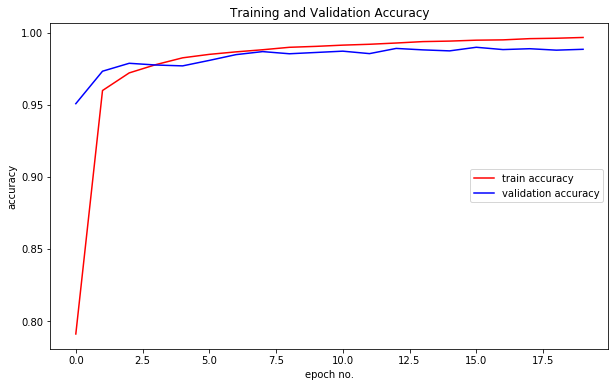

In [13]:
# Plot loss
plt.rcParams["figure.figsize"] = (10, 6)
x = range(len(epoch_train_loss))


plt.figure
plt.plot(x, epoch_train_acc, color='r', label="train accuracy")
plt.plot(x, epoch_test_acc, color='b', label="validation accuracy")
plt.xlabel('epoch no.')
plt.ylabel('accuracy')
plt.legend(loc='center right')
plt.title('Training and Validation Accuracy')
plt.show()

# Saving the Model 

In [14]:
models = './pretrained_model_list/'
if not os.path.exists(models):
    os.makedirs(models)
    
model_file_name = 'lenet5_mnist.pt'

model_path = os.path.join(models, model_file_name)

# make sure you transfer the model to cpu.
model.to('cpu')

# save the state_dict
torch.save(model.state_dict(), model_path)

***

# Loading the Model 
* Re-use the trained model 

In [15]:
# initialize the model
lenet5_mnist = LeNet5() 

# loading the model and getting model parameters by using load_state_dict
lenet5_mnist.load_state_dict(torch.load(model_path)) 

<All keys matched successfully>

# Model Prediction 

In [16]:
def prediction(model, train_config, batch_input):
    
    # send model to cpu/cuda according to your system configuration
    model.to(train_config.device)
    
    # it is important to do model.eval() before prediction
    model.eval()

    data = batch_input.to(train_config.device)

    output = model(data)

    # Score to probability using softmax
    prob = F.softmax(output, dim=1)

    # get the max probability
    pred_prob = prob.data.max(dim=1)[0]
    
    # get the index of the max probability
    pred_index = prob.data.max(dim=1)[1]
    
    return pred_index.cpu().numpy(), pred_prob.cpu().numpy()

# Perform Inference on sample images 

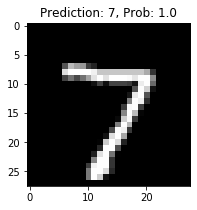

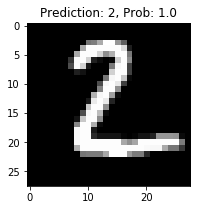

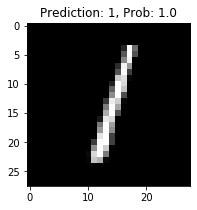

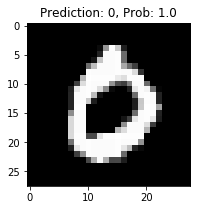

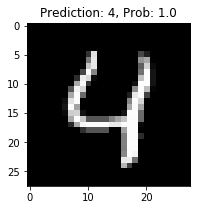

In [17]:
batch_size = 5
train_config = TrainingConfiguration()

# load test data without image transformation
test = torch.utils.data.DataLoader(
    datasets.MNIST(root=train_config.data_root, train=False, download=True, 
                   transform=transforms.functional.to_tensor),
    batch_size=batch_size,
    shuffle=False,
    num_workers=1
    )

# load testdata with image transformation
image_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307, ), (0.3081, ))
    ])

test_trans = torch.utils.data.DataLoader(
    datasets.MNIST(root=train_config.data_root, train=False, download=True, transform=image_transforms),
    batch_size=batch_size,
    shuffle=False,
    num_workers=1
    )

for data, _ in test_trans:
    # pass the loaded model
    pred, prob = prediction(lenet5_mnist, train_config, data)
    break
    

plt.rcParams["figure.figsize"] = (3, 3)
for images, _ in test:
    for i, img in enumerate(images):
        img = transforms.functional.to_pil_image(img)
        plt.imshow(img, cmap='gray')
        plt.gca().set_title('Prediction: {0}, Prob: {1:.2}'.format(pred[i], prob[i]))
        plt.show()
    break

# Effect of Batch Normalization 

In [18]:
from architectures.LeNetBatch import LeNetBN

In [19]:
modelBN = LeNetBN()

In [20]:
modelBN, epoch_train_loss_bn, epoch_train_acc_bn, epoch_test_loss_bn, epoch_test_acc_bn = main(modelBN)

Train Epoch: 0 [3200/60000] Loss: 1.911872 Acc: 0.5000
Train Epoch: 0 [6400/60000] Loss: 1.136220 Acc: 0.7812
Train Epoch: 0 [9600/60000] Loss: 0.505115 Acc: 0.9375
Train Epoch: 0 [12800/60000] Loss: 0.360511 Acc: 0.9688
Train Epoch: 0 [16000/60000] Loss: 0.176916 Acc: 1.0000
Train Epoch: 0 [19200/60000] Loss: 0.350777 Acc: 0.8438
Train Epoch: 0 [22400/60000] Loss: 0.161128 Acc: 0.9375
Train Epoch: 0 [25600/60000] Loss: 0.186483 Acc: 0.9375
Train Epoch: 0 [28800/60000] Loss: 0.508918 Acc: 0.8750
Train Epoch: 0 [32000/60000] Loss: 0.256317 Acc: 0.9688
Train Epoch: 0 [35200/60000] Loss: 0.131060 Acc: 0.9375
Train Epoch: 0 [38400/60000] Loss: 0.055151 Acc: 1.0000
Train Epoch: 0 [41600/60000] Loss: 0.065568 Acc: 1.0000
Train Epoch: 0 [44800/60000] Loss: 0.285075 Acc: 0.9062
Train Epoch: 0 [48000/60000] Loss: 0.032267 Acc: 1.0000
Train Epoch: 0 [51200/60000] Loss: 0.105261 Acc: 0.9688
Train Epoch: 0 [54400/60000] Loss: 0.038135 Acc: 0.9688
Train Epoch: 0 [57600/60000] Loss: 0.145858 Acc: 0.

Train Epoch: 7 [22400/60000] Loss: 0.017514 Acc: 1.0000
Train Epoch: 7 [25600/60000] Loss: 0.030239 Acc: 1.0000
Train Epoch: 7 [28800/60000] Loss: 0.058363 Acc: 0.9688
Train Epoch: 7 [32000/60000] Loss: 0.018863 Acc: 1.0000
Train Epoch: 7 [35200/60000] Loss: 0.028258 Acc: 1.0000
Train Epoch: 7 [38400/60000] Loss: 0.007127 Acc: 1.0000
Train Epoch: 7 [41600/60000] Loss: 0.003933 Acc: 1.0000
Train Epoch: 7 [44800/60000] Loss: 0.002708 Acc: 1.0000
Train Epoch: 7 [48000/60000] Loss: 0.001926 Acc: 1.0000
Train Epoch: 7 [51200/60000] Loss: 0.004224 Acc: 1.0000
Train Epoch: 7 [54400/60000] Loss: 0.029400 Acc: 1.0000
Train Epoch: 7 [57600/60000] Loss: 0.005090 Acc: 1.0000
Elapsed 140.21s, 17.53 s/epoch, 0.01 s/batch, ets 210.31s

Test set: Average loss: 0.0329, Accuracy: 9879/10000 (99%)

Train Epoch: 8 [3200/60000] Loss: 0.015195 Acc: 1.0000
Train Epoch: 8 [6400/60000] Loss: 0.012526 Acc: 1.0000
Train Epoch: 8 [9600/60000] Loss: 0.043867 Acc: 0.9688
Train Epoch: 8 [12800/60000] Loss: 0.051130 

Train Epoch: 14 [38400/60000] Loss: 0.001923 Acc: 1.0000
Train Epoch: 14 [41600/60000] Loss: 0.016926 Acc: 1.0000
Train Epoch: 14 [44800/60000] Loss: 0.014182 Acc: 1.0000
Train Epoch: 14 [48000/60000] Loss: 0.007092 Acc: 1.0000
Train Epoch: 14 [51200/60000] Loss: 0.078415 Acc: 0.9688
Train Epoch: 14 [54400/60000] Loss: 0.005660 Acc: 1.0000
Train Epoch: 14 [57600/60000] Loss: 0.002248 Acc: 1.0000
Elapsed 268.34s, 17.89 s/epoch, 0.01 s/batch, ets 89.45s

Test set: Average loss: 0.0287, Accuracy: 9899/10000 (99%)

Train Epoch: 15 [3200/60000] Loss: 0.001255 Acc: 1.0000
Train Epoch: 15 [6400/60000] Loss: 0.013738 Acc: 1.0000
Train Epoch: 15 [9600/60000] Loss: 0.001266 Acc: 1.0000
Train Epoch: 15 [12800/60000] Loss: 0.001711 Acc: 1.0000
Train Epoch: 15 [16000/60000] Loss: 0.003348 Acc: 1.0000
Train Epoch: 15 [19200/60000] Loss: 0.046487 Acc: 0.9688
Train Epoch: 15 [22400/60000] Loss: 0.002031 Acc: 1.0000
Train Epoch: 15 [25600/60000] Loss: 0.001302 Acc: 1.0000
Train Epoch: 15 [28800/60000] 

# Plot Loss 

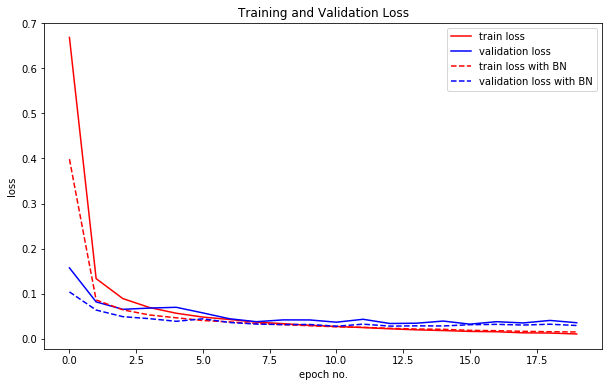

In [21]:
# Plot loss
plt.rcParams["figure.figsize"] = (10, 6)
x = range(len(epoch_train_loss))


plt.figure
plt.plot(x, epoch_train_loss, 'r', label="train loss")
plt.plot(x, epoch_test_loss, 'b', label="validation loss")

plt.plot(x, epoch_train_loss_bn, 'r--', label="train loss with BN")
plt.plot(x, epoch_test_loss_bn, 'b--',label="validation loss with BN")

plt.xlabel('epoch no.')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Miscellaneous: Calculate Mean and Standard Deviation of Fashion MNIST 

In [ ]:
import torchvision
train_transform = transforms.Compose([transforms.ToTensor()])
train_set = torchvision.datasets.FashionMNIST(root="./data_for_LeNet", train=True, download=True, transform=train_transform)

print(train_set.data.float().mean()/255)
print(train_set.data.float().std()/255)